#  Masking Pipeline

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)


In [5]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask)
from chxanalys.chx_libs import cmap_albula, cmap_vge, random
from chxanalys.chx_generic_functions import (get_detector, get_meta_data,create_user_folder,
                                             get_fields,  get_sid_filenames,load_data,  RemoveHot, show_img,get_avg_img, reverse_updown,create_cross_mask )
from skimage.draw import line_aa, line, polygon, circle
 
%matplotlib notebook

# Path for Saving Results

In [6]:
CYCLE= '2017_1'  #change clycle here

In [7]:
path = '/XF11ID/analysis/%s/masks/'%CYCLE
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2017_1/masks/


### Get the image series and metadata from the uid

In [73]:
uid = 'b9b1c5' # (scan num: 22070) (Measurement: direct beam position )
uid = '2d585b' # (scan num: 22071) (Measurement: no sample -> for mask )

uid = '337e48'

In [74]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [75]:
md = get_meta_data( uid )
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  22072--337e4897-ffc0-4a61-a0cb-1e088513d6ac--/XF11ID/data/2017/04/10/9c4cd38d-5bee-445f-933a_9968


In [76]:
print(md['beam_center_y'], md['beam_center_x'])

996.0 1094.0


In [77]:
imgs = load_data( uid, detector, reverse= False  )
#imgs = load_data( uid, detector, reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 5000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [78]:
pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [85]:
img_choice_N = 10  #can change this number to select more frames for average
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgs, img_samp_index, plot_ = False, uid = uid)

## show image and the pixel mask

* show image

<IPython.core.display.Javascript object>


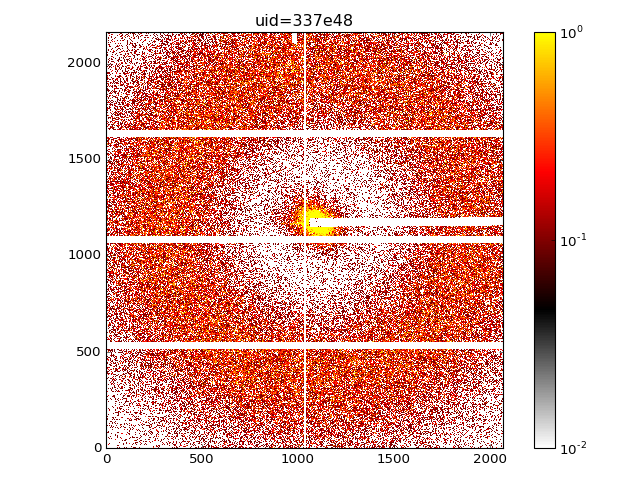

In [86]:
show_img(  avg_img*pixel_mask , vmin=.01, vmax=1, logs=True, 
         image_name ='uid=%s'%uid, aspect=1, cmap= cmap_albula  )


* pixel mask

<IPython.core.display.Javascript object>


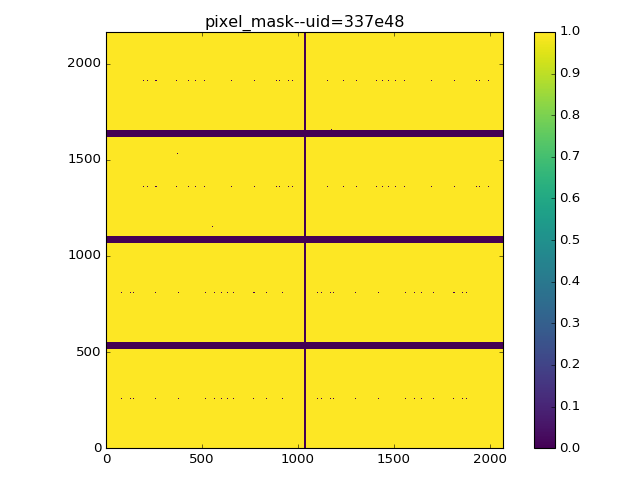

In [82]:
show_img( pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid ,aspect=1 )

## Remove hotspots in the image

In [29]:
#avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


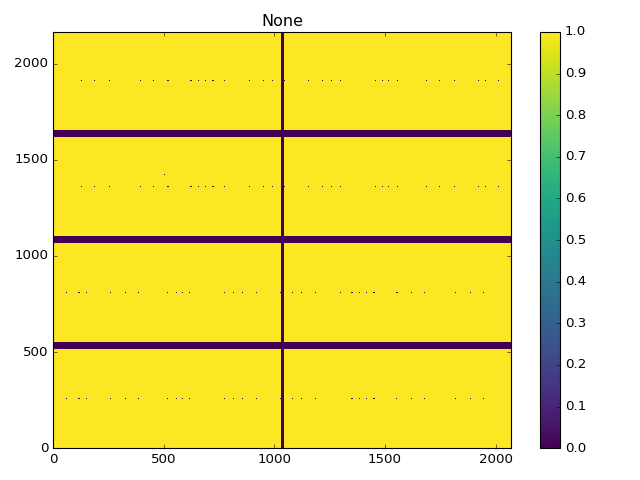

In [30]:
mask_rh  = RemoveHot( avg_img, 2**16-1, plot_=True)

<IPython.core.display.Javascript object>


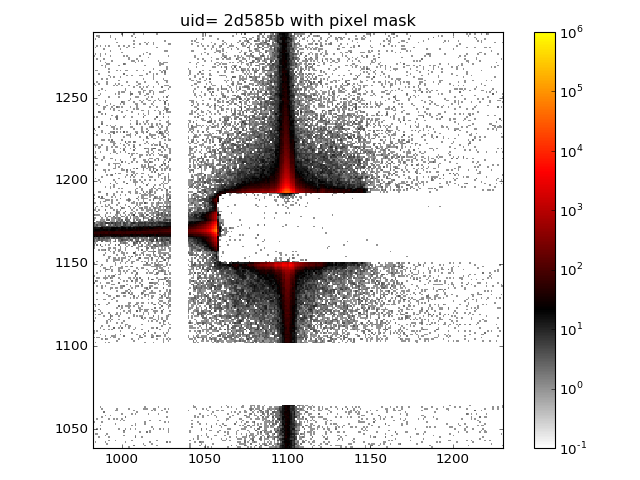

In [31]:
show_img(avg_img*pixel_mask,vmin=0.1,vmax=1e6, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula  )

# Create a polygon mask

* check beam center

In [32]:
#md['beam_center_x']= 513 #512 #512 -1;
#md['beam_center_y']= 161 # 155 #   89 -1
#md['beam_center_x'],2167-md['beam_center_y']

In [33]:
md['beam_center_x'], md['beam_center_y']

(1094.0, 996.0)

In [ ]:
#md['beam_center_x'] = 1080
#md['beam_center_y'] = 1127

### To create multi-rectangle masks, for each sub-mask



In [107]:
#creat the right part mask
partial_mask = create_cross_mask(  avg_img, center=[ 1045, 1169 ],
                            wy_left= 0, wy_right= 40, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )

<IPython.core.display.Javascript object>


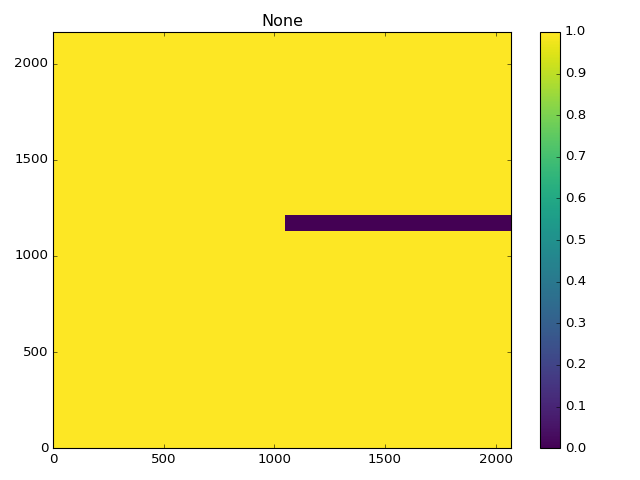

In [108]:
show_img(  partial_mask   )

In [110]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 1099, 1169],
                            wy_left= 30, wy_right= 30, 
                              wx_up= 30, wx_down=30,center_radius= 60 )
#partial_mask2[1285:1350,1430:1440,] = False

In [111]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 982, 2100],
                            wy_left= 0, wy_right= 0, 
                              wx_up= 20, wx_down= 0,center_radius= 0 )


<IPython.core.display.Javascript object>


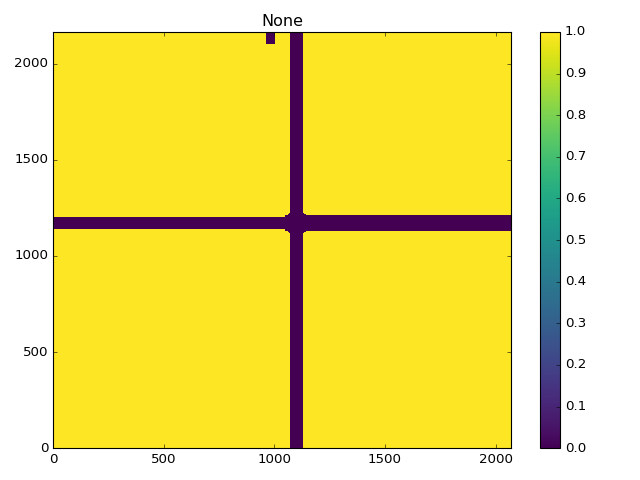

In [112]:
show_img(  partial_mask   )

In [116]:
#create a circle mask for windows
if False: #make it True to make window mask
    window_shadow  = ~create_cross_mask(  avg_img, center=[ 510, 140],
                           wy_left= 0, wy_right= 0, 
                             wx_up= 0, wx_down= 0,center_circle=True, center_radius= 580)
else:
    window_shadow = 1

In [114]:
full_mask = partial_mask *window_shadow

<IPython.core.display.Javascript object>


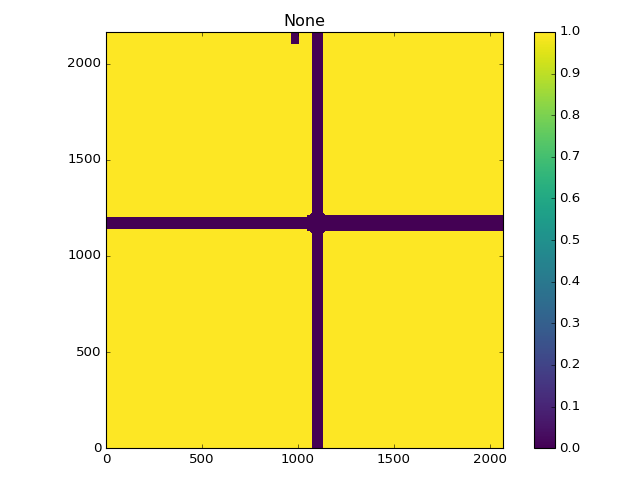

In [115]:
show_img( full_mask, aspect = 1 )

In [117]:
#mask = np.array ( full_mask * pixel_mask*mask_rh  , dtype = bool )
mask = np.array ( full_mask * pixel_mask , dtype = bool )

<IPython.core.display.Javascript object>


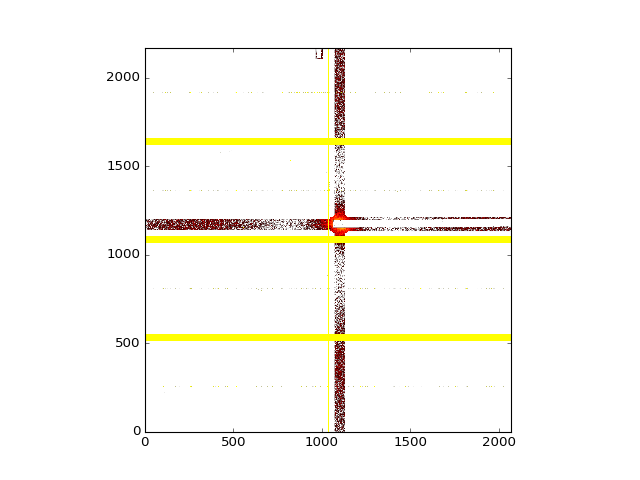

In [118]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax= 1e2 ), cmap= cmap_albula)
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


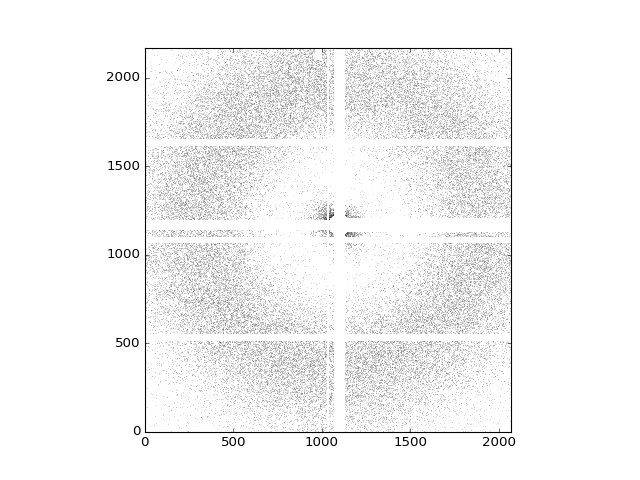

In [119]:
fig, ax = plt.subplots()
im = ax.imshow((mask)*avg_img,  cmap= cmap_albula,origin='lower',norm= LogNorm( vmin=.1, vmax=1e5 ),
               interpolation='none')
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


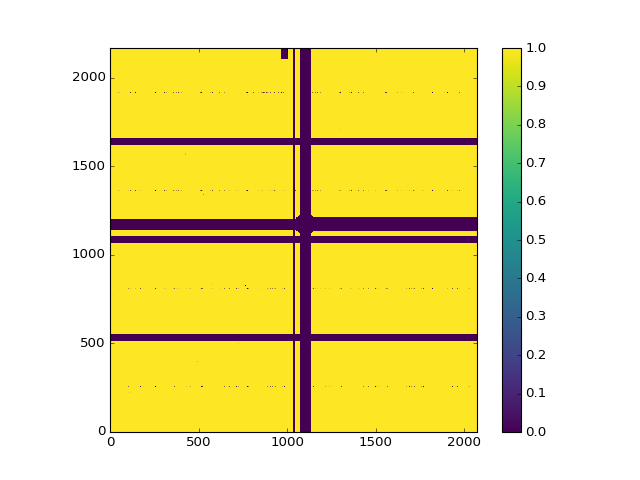

In [120]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [121]:
np.save(  path +   uid +"_mask", mask)

In [122]:
path +   uid +"_mask"

'/XF11ID/analysis/2017_1/masks/337e48_mask'

In [124]:
meaningful_name = 'Apr10_4M_SAXS16m_mask2' 

In [125]:
#np.save(  path +   meaningful_name, mask)

In [126]:
path +   meaningful_name

'/XF11ID/analysis/2017_1/masks/Apr10_4M_SAXS16m_mask2'